# nGram Classification 2

In [163]:
import re, csv, string, random
from collections import Counter, defaultdict
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score
import matplotlib.pyplot as plt
import numpy as np

In [164]:
MAX_LEN = 128
N = 5          # n-gram model
TOP_K = 150    # profile size

In [165]:
def load_corpus(csv_file):
    """Load corpus from a CSV file with 'text' column."""
    real, fake = [], []
    with open(csv_file, newline='', encoding='utf-8') as f:
        reader = csv.DictReader(f)
        for row in reader:
            if int(row["label"]) == 1:
                real.append(row['text'])
            else:
                fake.append(row['text'])
    return real, fake

def normalize_text(text):
    """Basic normalization similar to Cavnar & Trenkle."""
    text = text.lower()
    text = re.sub(r"\s+", " ", text)
    return text


def extract_ngrams(text, n=3):
    """Extract all character n-grams from text."""
    text = normalize_text(text)
    return [text[i:i+n] for i in range(len(text)-n+1)]


def build_profile(texts, n=3, top_k=300):
    """
    Build an n-gram frequency profile.
    Returns dict: {ngram: rank}
    """
    counter = Counter()
    for t in texts:
        counter.update(extract_ngrams(t, n=n))

    # Sort n-grams by frequency
    most_common = counter.most_common(top_k)

    # Convert to rank profile: {ngram: rank_index}
    profile = {ngram: rank for rank, (ngram, _) in enumerate(most_common)}
    return profile


def out_of_place_distance(profile_ref, profile_cmp, penalty=300):
    """
    Compute the out-of-place distance between two profiles.
    profile_ref: reference ngram->rank
    profile_cmp: ngram->rank of text to classify
    penalty: distance if ngram not found
    """
    distance = 0
    for ngram, rank_ref in profile_ref.items():
        rank_cmp = profile_cmp.get(ngram, penalty)
        distance += abs(rank_ref - rank_cmp)
    return distance


def classify(text, real_profile, random_profile, n=3, top_k=300, penalty=300):
    """
    Classify text as REAL or RANDOM using the out-of-place measure.
    """
    # Build test text profile
    ngrams = extract_ngrams(text, n=n)
    freq = Counter(ngrams).most_common(top_k)
    test_profile = {ng: rank for rank, (ng, _) in enumerate(freq)}

    # Compare to profiles
    d_real = out_of_place_distance(real_profile, test_profile, penalty=penalty)
    d_rand = out_of_place_distance(random_profile, test_profile, penalty=penalty)

    return 1 if d_real < d_rand else 0, d_real, d_rand


## Training

In [166]:
# Training corpus
real_texts, random_texts = load_corpus(f"datasets/train_dataset_{MAX_LEN}.csv")

# Build language profiles
real_profile = build_profile(real_texts, n=N, top_k=TOP_K)
random_profile = build_profile(random_texts, n=N, top_k=TOP_K)

## Evaluate

### Metrics

In [167]:
real_texts, random_texts = load_corpus(f"datasets/val_dataset_{MAX_LEN}.csv")

y_true = [1] * len(real_texts) + [0] * len(random_texts)
y_pred = []
drs = []
dns = []

for text in real_texts:
    cls, dr, dn = classify(text, real_profile, random_profile, n=N, top_k=TOP_K)
    y_pred.append(cls)
    drs.append(dr)
    dns.append(dn)
for text in random_texts:
    cls, dr, dn = classify(text, real_profile, random_profile, n=N, top_k=TOP_K)
    y_pred.append(cls)
    drs.append(dr)
    dns.append(dn)

print(f"Accuracy: {accuracy_score(y_true, y_pred):.4f}")
print(f"Precision: {precision_score(y_true, y_pred, zero_division=0):.4f}")
print(f"Recall: {recall_score(y_true, y_pred, zero_division=0):.4f}")
print(f"F1 Score: {f1_score(y_true, y_pred, zero_division=0):.4f}")

Accuracy: 0.9760
Precision: 0.9837
Recall: 0.9680
F1 Score: 0.9758


### Adversarial attack

In [168]:
def predict(text, real_profile, random_profile, n=N, top_k=TOP_K):
    cls, dr, dn = classify(text, real_profile, random_profile, n=n, top_k=top_k)
    score = dr / (dr + dn)
    return score

In [169]:
def random_uniform_like(n):
    """Uniform random characters."""
    chars = string.ascii_lowercase + "   "
    return ''.join(random.choice(chars) for _ in range(n))


def random_markov_like(n):
    """Produce pseudo-word sequences that look a bit structured but are gibberish."""
    consonants = "bcdfghjklmnpqrstvwxyz  "
    vowels = "aeiou  "
    s = ""
    for _ in range(n):
        pattern = random.choice([
            random.choice(consonants),
            random.choice(vowels),
            random.choice(consonants) + random.choice(vowels),
            random.choice(vowels) + random.choice(consonants)
        ])
        s += pattern
    return s[:n]

def adversarial_attack(max_ite=200, samples=10, plot=True):
    scores_history = np.zeros((len(range(10,MAX_LEN+1,50)), samples, max_ite))
    j = 0
    for n in range(10,MAX_LEN+1,50):
        for e in range(samples//2):
            rand_seq = random_uniform_like(n)
            score = predict(rand_seq, real_profile, random_profile)

            for i in range(max_ite):
                chars = "bcdfghjklmnpqrstvwxyz aeiou "
                pos = random.randint(0, len(rand_seq)-1)
                new_char = random.choice(chars)
                new_seq = rand_seq[:pos] + new_char + rand_seq[pos+1:]
                new_score = predict(new_seq, real_profile, random_profile)
                if new_score > score:
                    rand_seq = new_seq
                    score = new_score
                scores_history[j, e, i] = score
        for e in range(samples//2):
            rand_seq = random_markov_like(n)
            score = predict(rand_seq, real_profile, random_profile)

            for i in range(max_ite):
                chars = "bcdfghjklmnpqrstvwxyz aeiou "
                pos = random.randint(0, len(rand_seq)-1)
                new_char = random.choice(chars)
                new_seq = rand_seq[:pos] + new_char + rand_seq[pos+1:]
                new_score = predict(new_seq, real_profile, random_profile)
                if new_score > score:
                    rand_seq = new_seq
                    score = new_score
                scores_history[j, e+samples//2, i] = score

        if plot:
            plt.figure(figsize=(4, 3))
            plt.plot(scores_history[j].T)
            # color the area where the string wolud get recognized as real (0.5 threshold)
            plt.fill_between(range(scores_history.shape[2]), 0.5, 1, color='red', alpha=0.2)
            plt.xlabel("Iteration")
            plt.yticks([0.0, 0.25, 0.5, 0.75, 1.0])
            plt.ylabel("Predicted Real Text Score")
            plt.title(f"Evolution of Random Sequence Scores for n={n}")
            plt.show()
        
        j+=1
    return scores_history

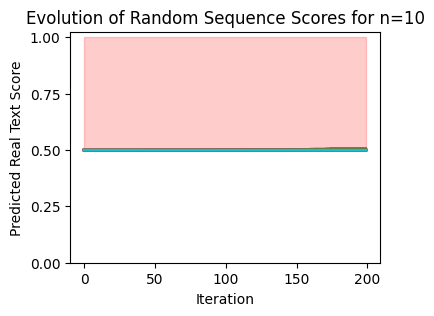

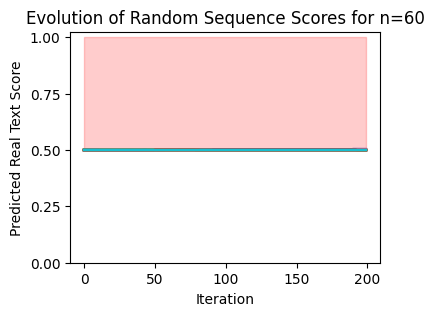

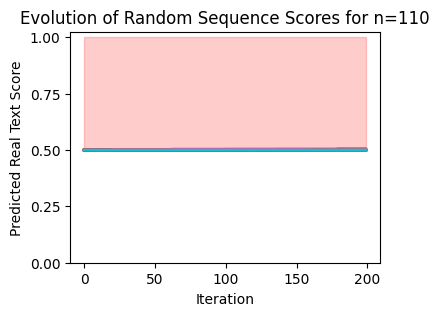

In [170]:
h = adversarial_attack(max_ite=200, samples=100, plot=True)

In [171]:
print("Adv @10: ", np.sum(h[0, :, -1] > 0.5)/len(h[0, :, -1]))
print("Adv @60: ", np.sum(h[1, :, -1] > 0.5)/len(h[0, :, -1]))
print("Adv @110: ", np.sum(h[2, :, -1] > 0.5)/len(h[0, :, -1]))

Adv @10:  0.07
Adv @60:  0.18
Adv @110:  0.27


## Test

In [172]:
# Testing
test_text_real = "Natural language processing allows computers to read text."
test_text_random = "argo lfd alnkdf lnasgpi sdfas njs a "

print("Testing real text:")
cls, dr, dn = classify(test_text_real, real_profile, random_profile, n=N, top_k=TOP_K)
print("Class:", "REAL" if cls == 1 else "RANDOM", "| Distance to REAL:", dr, "| Distance to RANDOM:", dn)

print("\nTesting random noise:")
cls, dr, dn = classify(test_text_random, real_profile, random_profile, n=N, top_k=TOP_K)
print("Class:", "REAL" if cls == 1 else "RANDOM", "| Distance to REAL:", dr, "| Distance to RANDOM:", dn)

Testing real text:
Class: REAL | Distance to REAL: 33673 | Distance to RANDOM: 33825

Testing random noise:
Class: RANDOM | Distance to REAL: 33825 | Distance to RANDOM: 33825
